In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)    

In [0]:
print(torch.__version__)
print(torchvision.__version__)

1.5.0+cu101
0.6.0+cu101


In [0]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw




Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

In [0]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [0]:
# import modules to build RunBuilder and RunManager helper classes
from collections  import OrderedDict
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

In [0]:
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images)

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further a
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [0]:
params = OrderedDict(
    lr = [.01, .001],
    batch_size = [100, 1000],
    shuffle = [False]
)
epochs = 5

In [0]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = Network()
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0]
        labels = batch[1]
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,0.584180,0.775983,14.614163,16.198647,0.010,100,False
1,1,2,0.394990,0.852817,14.592173,30.920775,0.010,100,False
2,1,3,0.362507,0.865367,14.548952,45.580137,0.010,100,False
3,1,4,0.354859,0.869483,14.547323,60.239344,0.010,100,False
4,1,5,0.337718,0.875200,14.669595,75.024367,0.010,100,False
5,2,1,0.954908,0.633183,13.402142,14.273704,0.010,1000,False
6,2,2,0.506021,0.807250,13.386678,27.774588,0.010,1000,False
7,2,3,0.413937,0.848183,13.394114,41.286155,0.010,1000,False
8,2,4,0.367214,0.863883,13.290732,54.688770,0.010,1000,False
9,2,5,0.338865,0.873967,13.323423,68.126266,0.010,1000,False


In [0]:
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat(
        (all_preds, preds),
        dim = 0
    )
  return all_preds

In [0]:
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=1000)
train_preds = get_all_preds(network, prediction_loader)

In [0]:
!pip install scikit-plot

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2020-05-23 12:59:10--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.228.174.189, 54.165.223.176, 18.213.76.145, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.228.174.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  61.7MB/s    in 0.2s    

2020-05-23 12:59:10 (61.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './runs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://3f80f329.ngrok.io


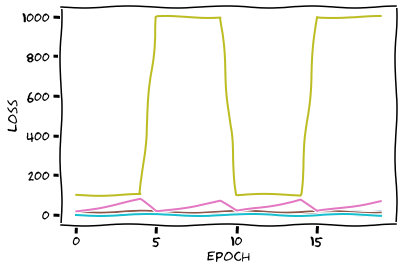

In [0]:
losses=pd.read_csv('/content/results.csv')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses)
plt.show()

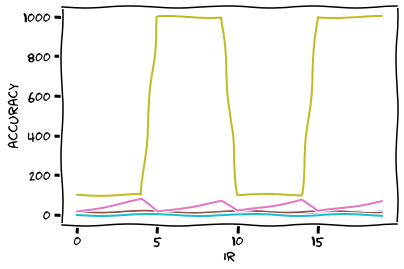

In [0]:
accuracy=pd.read_csv('/content/results.csv')
plt.xlabel('Ir')
plt.ylabel('accuracy')
plt.plot(accuracy)
plt.show()